# Proyecto 2
## Modelo CNN para la clasificación de imágenes. 80%
### by: Luis Hector Camarillo Amador

In [1]:
#%pip install -r requirements.txt

In [2]:
from keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import Sequential
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm
import pandas as pd
import seaborn as sns
from PIL import Image, ImageFilter, ImageEnhance
import cv2

2025-04-24 20:15:52.627466: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-24 20:15:52.631588: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-24 20:15:52.643036: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745547352.661401   45350 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745547352.666503   45350 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745547352.681101   45350 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [3]:
# Configuracion Inicial
IMG_SIZE = 150
BATCH_SIZE = 32
EPOCHS = 10

# Directorios 
train_dir = '/home/relka/Descargas/Diplomado_Oficial/Módulo 6 - Redes Neuronales profundas/Proyecto2/seg_train/seg_train'
test_dir = '/home/relka/Descargas/Diplomado_Oficial/Módulo 6 - Redes Neuronales profundas/Proyecto2/seg_test/seg_test'
pred_dir = '/home/relka/Descargas/Diplomado_Oficial/Módulo 6 - Redes Neuronales profundas/Proyecto2/seg_pred/'



In [4]:
# Cargamos los datos de entrenamiento
filepaths_train, labels_train = [], []
for i in os.listdir(train_dir):
    foldpath = os.path.join(train_dir, i)
    for j in tqdm(os.listdir(foldpath)):
        filepaths_train.append(os.path.join(foldpath, j))
        labels_train.append(i)

100%|██████████| 2274/2274 [00:00<00:00, 955504.64it/s]


In [5]:
# Cargamos los datos de prueba
filepaths_test, label_test = [],[]
for i in os.listdir(test_dir):
    foldpath = os.path.join(test_dir, i)
    for j in tqdm(os.listdir(foldpath)):
        filepaths_test.append(os.path.join(foldpath, j))
        label_test.append(i)


100%|██████████| 510/510 [00:00<00:00, 1007106.89it/s]


In [6]:
# Cargamos los datos que usaremos para predicir
filepaths_pred, label_pred = [], []
for i in os.listdir(pred_dir):
    foldpath=os.path.join(pred_dir,i)
    for j in tqdm(os.listdir(foldpath)):
        filepaths_pred.append(os.path.join(foldpath,j))
        label_pred.append(i)


100%|██████████| 7301/7301 [00:00<00:00, 1088030.33it/s]


In [7]:
df_train = pd.DataFrame({'filepath_train':filepaths_train, 'label_train':labels_train})
df_test = pd.DataFrame({'filepath_test':filepaths_test, 'label_test':label_test})
df_pred = pd.DataFrame({'filepath_pred':filepaths_pred, 'label_pred':label_pred})



/tmp/ipykernel_45350/4219413331.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_train['label_train'], palette=color)
/tmp/ipykernel_45350/4219413331.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_test['label_test'], palette=color)


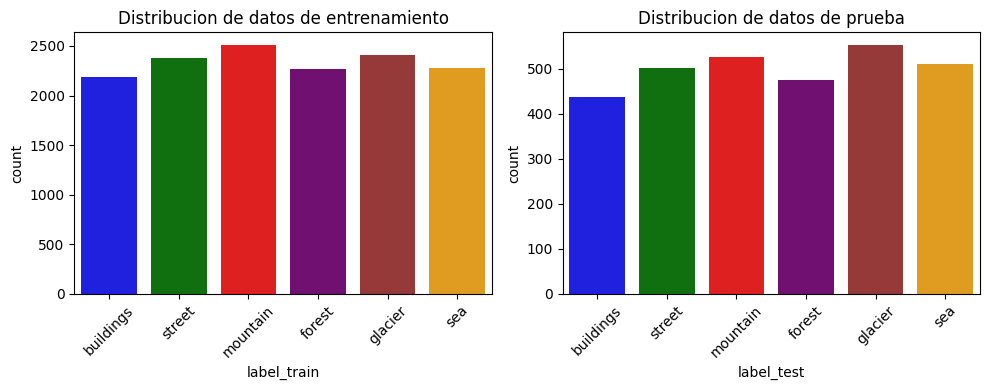

In [8]:
## Graficar la distribución de los datos
color = ['blue', 'green', 'red', 'purple', 'brown','orange']
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.countplot(x=df_train['label_train'], palette=color)
plt.title('Distribucion de datos de entrenamiento')
plt.xticks(rotation=45)
plt.subplot(1, 2, 2)
sns.countplot(x=df_test['label_test'], palette=color)
plt.title('Distribucion de datos de prueba')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [9]:
# Preprcesamiento de datos

# filtro sobel
def apply_sobel_filter(image):
    image = (image * 255).astype(np.uint8)

    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)  # Bordes horizontales

    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)  # Bordes verticales

    sobel = np.sqrt(sobelx**2 + sobely**2)

    sobel = cv2.normalize(sobel, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    sobel_rgb = cv2.cvtColor(sobel, cv2.COLOR_GRAY2RGB)

    sobel_rgb = sobel_rgb.astype(np.float32) / 255.0

    return sobel_rgb 

data_gen = ImageDataGenerator(rescale=1./255,
                              rotation_range=20,
                              width_shift_range = 0.2,
                              height_shift_range = 0.2,
                              horizontal_flip=True,
                              validation_split=0.2,
                              preprocessing_function=apply_sobel_filter #filtro sobel
                              )


train_gen = data_gen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_gen = data_gen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

class_dict = train_gen.class_indices


Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.


In [10]:
data_test_gen = ImageDataGenerator(rescale=1./255,
                                   preprocessing_function=apply_sobel_filter)
test_generator = data_test_gen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 3000 images belonging to 6 classes.


In [11]:
# Creacion del modelo CNN
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adamax


In [12]:
model= Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dense(6, activation='softmax')
])

/home/relka/Descargas/Diplomado_Oficial/Módulo 6 - Redes Neuronales profundas/Proyecto2/venv_proyecto2/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-04-24 20:15:55.790085: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [13]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     6,423,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,814,534 (26.00 MB)

 Trainable params: 6,814,534 (26.00 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Entreamiento del modelo
history = model.fit(train_gen,steps_per_epoch=train_gen.samples//BATCH_SIZE,epochs=EPOCHS,validation_data=validation_gen,validation_steps=validation_gen.samples//BATCH_SIZE)


/home/relka/Descargas/Diplomado_Oficial/Módulo 6 - Redes Neuronales profundas/Proyecto2/venv_proyecto2/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 226s 643ms/step - accuracy: 0.1745 - loss: 1.7920 - val_accuracy: 0.1789 - val_loss: 1.7910
Epoch 2/10
  1/350 ━━━━━━━━━━━━━━━━━━━━ 3:25 588ms/step - accuracy: 0.2188 - loss: 1.7951

/home/relka/Descargas/Diplomado_Oficial/Módulo 6 - Redes Neuronales profundas/Proyecto2/venv_proyecto2/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


350/350 ━━━━━━━━━━━━━━━━━━━━ 21s 57ms/step - accuracy: 0.2188 - loss: 1.7951 - val_accuracy: 0.1796 - val_loss: 1.7908
Epoch 3/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 226s 645ms/step - accuracy: 0.1812 - loss: 1.7911 - val_accuracy: 0.1792 - val_loss: 1.7910
Epoch 4/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - accuracy: 0.1562 - loss: 1.7951 - val_accuracy: 0.1789 - val_loss: 1.7911
Epoch 5/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 224s 640ms/step - accuracy: 0.1710 - loss: 1.7919 - val_accuracy: 0.1782 - val_loss: 1.7909
Epoch 6/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 21s 57ms/step - accuracy: 0.1875 - loss: 1.7932 - val_accuracy: 0.1792 - val_loss: 1.7908
Epoch 7/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 222s 635ms/step - accuracy: 0.1858 - loss: 1.7904 - val_accuracy: 0.1785 - val_loss: 1.7908
Epoch 8/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - accuracy: 0.0312 - loss: 1.8055 - val_accuracy: 0.1789 - val_loss: 1.7908
Epoch 9/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 199s 569ms/step - accuracy: 0.1763 - loss: 1.7913 - val

351/351 ━━━━━━━━━━━━━━━━━━━━ 72s 205ms/step - accuracy: 0.1761 - loss: 1.7908
[1.7908010482788086, 0.1789848655462265]
94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 119ms/step - accuracy: 0.0993 - loss: 1.8163
[1.7903108596801758, 0.17499999701976776]
88/88 ━━━━━━━━━━━━━━━━━━━━ 19s 211ms/step - accuracy: 0.1765 - loss: 1.7906
[1.7908040285110474, 0.17902995645999908]


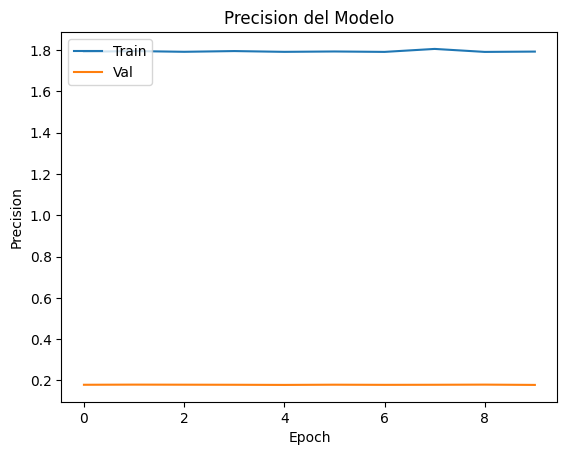

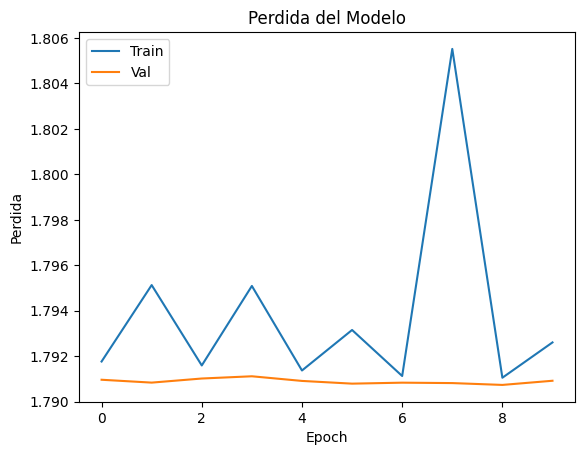

In [15]:
# Graficas de presicion y perdida

print(model.evaluate(train_gen))
print(model.evaluate(test_generator))
print(model.evaluate(validation_gen))

plt.plot(history.history['loss'])
plt.plot(history.history['val_accuracy'])
plt.title('Precision del Modelo')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Perdida del Modelo')
plt.ylabel('Perdida')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()


In [16]:
# Creamos una funcion para predicir la clase de una imagen

def predict(img_path):
    try:
        label = list(class_dict.keys())
        print("Labels:", label)

        img = Image.open(img_path)
        resized_img = img.resize((IMG_SIZE, IMG_SIZE))
        img_array = np.asarray(resized_img) / 255.0


        img_array = apply_sobel_filter(img_array)

        img_array = np.expand_dims(img_array, axis=0)
        predictions = model.predict(img_array)
        probs = predictions[0]
        print("Probabilidad de predicción:", probs)

        plt.figure(figsize=(8, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(resized_img)
        plt.axis('off')

        plt.subplot(1, 2, 2)
        bars = plt.barh(label, probs)
        plt.xlabel('Probabilidad')
        ax = plt.gca()
        ax.bar_label(bars, fmt='%.2f')
        plt.tight_layout()
        plt.grid(True)
        plt.show()

    except Exception as e:
        print(f"An error occurred: {e}")

Labels: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Probabilidad de predicción: [0.1456024  0.1724591  0.17790797 0.181965   0.15528458 0.16678104]


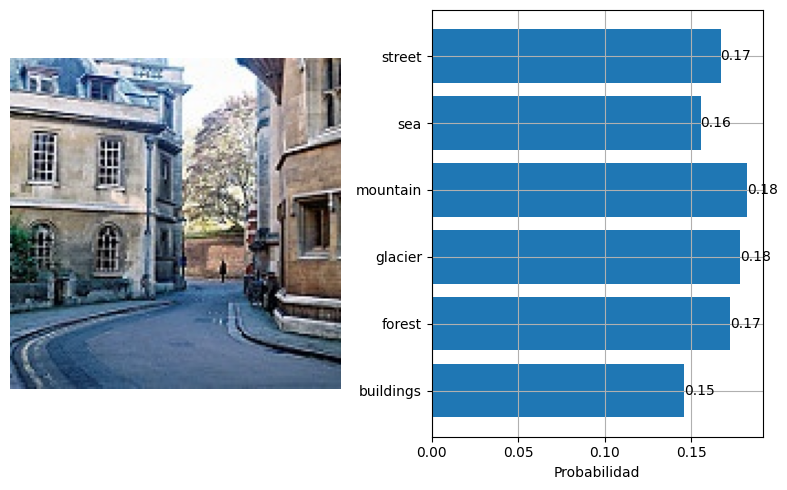

In [34]:
sample_img_path = df_pred.sample(1)['filepath_pred'].values[0]

predict(sample_img_path)

# Modelo sin filtro sobel

In [35]:
# Preprcesamiento de datos

data_gen = ImageDataGenerator(rescale=1./255,
                              rotation_range=20,
                              width_shift_range = 0.2,
                              height_shift_range = 0.2,
                              horizontal_flip=True,
                              validation_split=0.2,
                              #preprocessing_function=apply_sobel_filter filtro sobel
                              )


train_gen = data_gen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_gen = data_gen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

class_dict = train_gen.class_indices


Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.


In [36]:
# Entreamiento del modelo
history = model.fit(train_gen,steps_per_epoch=train_gen.samples//BATCH_SIZE,epochs=EPOCHS,validation_data=validation_gen,validation_steps=validation_gen.samples//BATCH_SIZE)




Epoch 1/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 225s 644ms/step - accuracy: 0.3657 - loss: 1.5501 - val_accuracy: 0.5887 - val_loss: 1.0505
Epoch 2/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 19s 53ms/step - accuracy: 0.5938 - loss: 0.8612 - val_accuracy: 0.5970 - val_loss: 1.0114
Epoch 3/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 214s 612ms/step - accuracy: 0.5965 - loss: 1.0238 - val_accuracy: 0.6505 - val_loss: 0.9011
Epoch 4/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.4688 - loss: 1.2124 - val_accuracy: 0.5934 - val_loss: 1.0654
Epoch 5/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 247s 706ms/step - accuracy: 0.6706 - loss: 0.8777 - val_accuracy: 0.7367 - val_loss: 0.7252
Epoch 6/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 20s 55ms/step - accuracy: 0.6875 - loss: 0.8233 - val_accuracy: 0.6753 - val_loss: 0.8854
Epoch 7/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 212s 606ms/step - accuracy: 0.7120 - loss: 0.7754 - val_accuracy: 0.7435 - val_loss: 0.6880
Epoch 8/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.7812 - loss: 0

351/351 ━━━━━━━━━━━━━━━━━━━━ 68s 195ms/step - accuracy: 0.7607 - loss: 0.6530
[0.649336576461792, 0.7624220848083496]
94/94 ━━━━━━━━━━━━━━━━━━━━ 13s 139ms/step - accuracy: 0.2391 - loss: 2.4040
[2.1551899909973145, 0.15800000727176666]
88/88 ━━━━━━━━━━━━━━━━━━━━ 17s 196ms/step - accuracy: 0.7539 - loss: 0.6651
[0.6690934896469116, 0.7546362280845642]


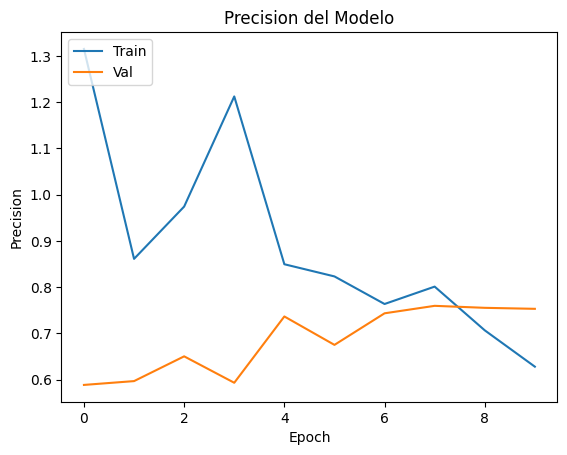

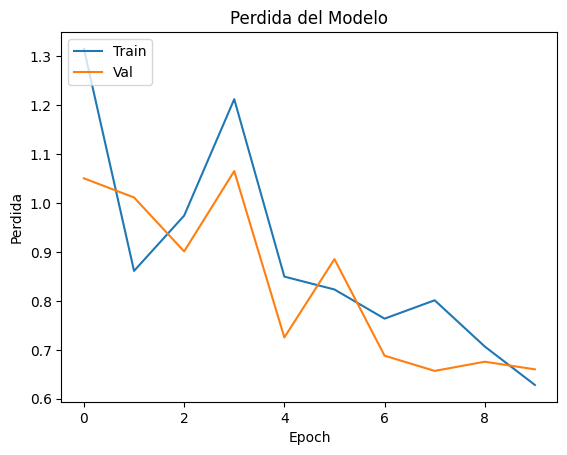

In [37]:
# Graficas de presicion y perdida

print(model.evaluate(train_gen))
print(model.evaluate(test_generator))
print(model.evaluate(validation_gen))

plt.plot(history.history['loss'])
plt.plot(history.history['val_accuracy'])
plt.title('Precision del Modelo')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Perdida del Modelo')
plt.ylabel('Perdida')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()


In [38]:
# Creamos una funcion para predicir la clase de una imagen

def predict(img_path):
    try:
        label = list(class_dict.keys())
        print("Labels:", label)

        img = Image.open(img_path)
        resized_img = img.resize((IMG_SIZE, IMG_SIZE))
        img_array = np.asarray(resized_img) / 255.0


        img_array = apply_sobel_filter(img_array)

        img_array = np.expand_dims(img_array, axis=0)
        predictions = model.predict(img_array)
        probs = predictions[0]
        print("Probabilidad de predicción:", probs)

        plt.figure(figsize=(8, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(resized_img)
        plt.axis('off')

        plt.subplot(1, 2, 2)
        bars = plt.barh(label, probs)
        plt.xlabel('Probabilidad')
        ax = plt.gca()
        ax.bar_label(bars, fmt='%.2f')
        plt.tight_layout()
        plt.grid(True)
        plt.show()

    except Exception as e:
        print(f"An error occurred: {e}")

Labels: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Probabilidad de predicción: [4.4169914e-02 2.2274639e-01 1.3025284e-03 4.4476023e-05 3.7847151e-04
 7.3135817e-01]


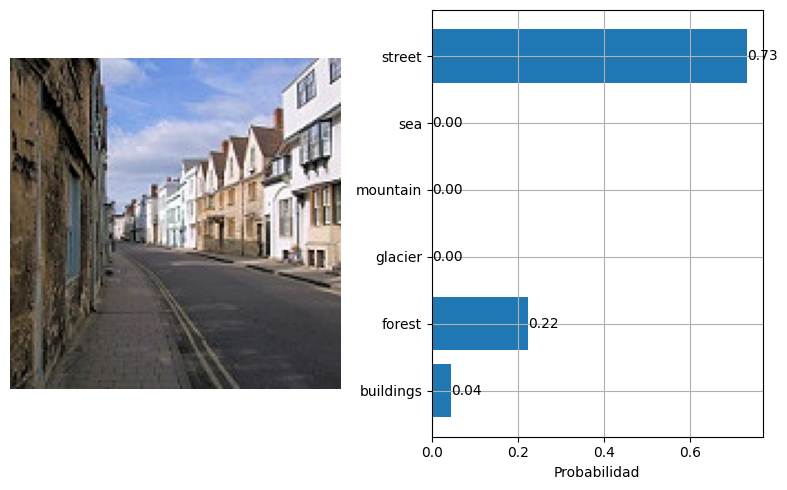

In [53]:
sample_img_path = df_pred.sample(1)['filepath_pred'].values[0]

predict(sample_img_path)